# RF6 Project Contributors

In [1]:
import json
import pandas as pd
from scripts.agora import agora_api
from scripts.farcaster import load_farcaster

# Process Farcaster and Badgeholders

In [2]:
#refresh_farcaster()
f = load_farcaster()

farcaster_users = pd.DataFrame(f)[['fid', 'username']].drop_duplicates().set_index('fid')['username'].to_dict()
farcaster_linked_addresses = pd.DataFrame(f)[['fid', 'address']].dropna().groupby('fid')['address'].apply(set).to_dict()
farcaster_address_to_id = pd.DataFrame(f)[['fid', 'address']].dropna().set_index('address')['fid'].to_dict()

In [3]:
def load_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

badgeholder_attestation_data = load_json('data/attestations/599.json')
print("Badgeholder attestations:", len(badgeholder_attestation_data))

Badgeholder attestations: 305


In [4]:
def convert_farcaster(farcaster_id):
    return int(farcaster_id['hex'], 16) if farcaster_id else None

badgeholders = []

for a in badgeholder_attestation_data:
    if a['attester'] != '0xE4553b743E74dA3424Ac51f8C1E586fd43aE226F':
        continue
    if a['voterType'] == 'Guest':
        continue

    addr = a['recipient'].lower()
    fid = convert_farcaster(a['farcasterID'])
    username = farcaster_users.get(fid, '')
    badgeholders.append({
        'address': addr,
        'farcaster_id': fid,
        'farcaster_username': username,
        'source': 'attestation_schema_599'
    })
    linked_addresses = farcaster_linked_addresses.get(fid, [])
    for addr in linked_addresses:
        badgeholders.append({
            'address': addr.lower(),
            'farcaster_id': fid,
            'farcaster_username': username,
            'source': 'farcaster_linked_address'
        })

df_badgeholders = pd.DataFrame(badgeholders)
badgeholder_fids = set(df_badgeholders['farcaster_id'].unique())
df_badgeholders.tail(1)

,address,farcaster_id,farcaster_username,source
419,0xfb0a98121c3939657e59f835c66cfe20abb0cd4f,233135,krzkaczor,attestation_schema_599


In [5]:
rf6_projects = agora_api('retrofunding/rounds/6/projects')

Fetched a total of 88 items from retrofunding/rounds/6/projects.


In [6]:
df = pd.DataFrame(rf6_projects)
df['organization_name'] = df['organization'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
df['team_fids'] = df['team'].apply(lambda team: [x['fid'] for x in team] if isinstance(team, list) else [])
df['num_badgeholders'] = df['team_fids'].apply(lambda x: len(set(x).intersection(badgeholder_fids)))
df['team_usernames'] = df['team'].apply(lambda team: [x['username'] for x in team] if isinstance(team, list) else [])
df['has_github'] = df['github'].apply(lambda x: len(x)>0)
df['has_contracts'] = df['contracts'].apply(lambda x: len(x)>0)
df['has_venture_funding'] = df['grantsAndFunding'].apply(lambda x: len(x.get('ventureFunding',[]))>0)
df['has_revenue'] = df['grantsAndFunding'].apply(lambda x: len(x.get('revenue',[]))>0)

def get_grants(g):
    lst = g.get('grants')
    total = 0
    if lst:
        for x in lst:
            a = x['amount']
            try:
                total += pd.to_numeric(a)
            except:
                a = 0
    return total

df['past_grants'] = df['grantsAndFunding'].apply(get_grants)
df['past_retrofunding'] = df['grantsAndFunding'].apply(lambda rf: sum([pd.to_numeric(x['amount']) for x in rf.get('retroFunding', [{'amount': 0}])]))

cols = [
    'applicationId', 'projectId', 'applicationCategory', 'organization_name', 'name',
    'has_github', 'has_contracts', 'has_venture_funding',
    'has_revenue', 'past_grants', 'past_retrofunding', 'team_usernames', 'num_badgeholders'
]

df_projects = df[cols].sort_values(by=['organization_name', 'name'])
df_projects.tail(1)

,applicationId,projectId,applicationCategory,organization_name,name,has_github,has_contracts,has_venture_funding,has_revenue,past_grants,past_retrofunding,team_usernames,num_badgeholders
10,0x2c269a72b290769e77786afdea519aab34b4b96964d0...,0x431eb34f7f4cfd3c8eda4c60e32bf1cc0bf292d30514...,GOVERNANCE_ANALYTICS,None,numbaNERDs,False,False,False,False,75000,69565.0,[chain-l],0


In [7]:
users = []
for app in rf6_projects:
    org = app.get('organization', {})
    org_name = org.get('name') if org else None
    team = app.get('team')
    if not team:
        continue
    for u in team:
        users.append({
            'fid': u['fid'],
            'username': u['username'],
            'organization_name': org_name,            
            'project_name': app['name'],
            'project_id': app['projectId'],
            'is_badgeholder': u['fid'] in badgeholder_fids
        })

df_users = pd.DataFrame(users).sort_values(by=['username', 'organization_name', 'project_name'])
df_users.tail(1)

,fid,username,organization_name,project_name,project_id,is_badgeholder
109,488597,zeptimus,None,Pairwise,0x98877a3c5f3d5eee496386ae93a23b17f0f51b70b304...,False


In [8]:
df_projects.to_csv('data/rf6_project_applications.csv', index=0)
df_users.to_csv('data/rf6_users_by_project.csv', index=0)

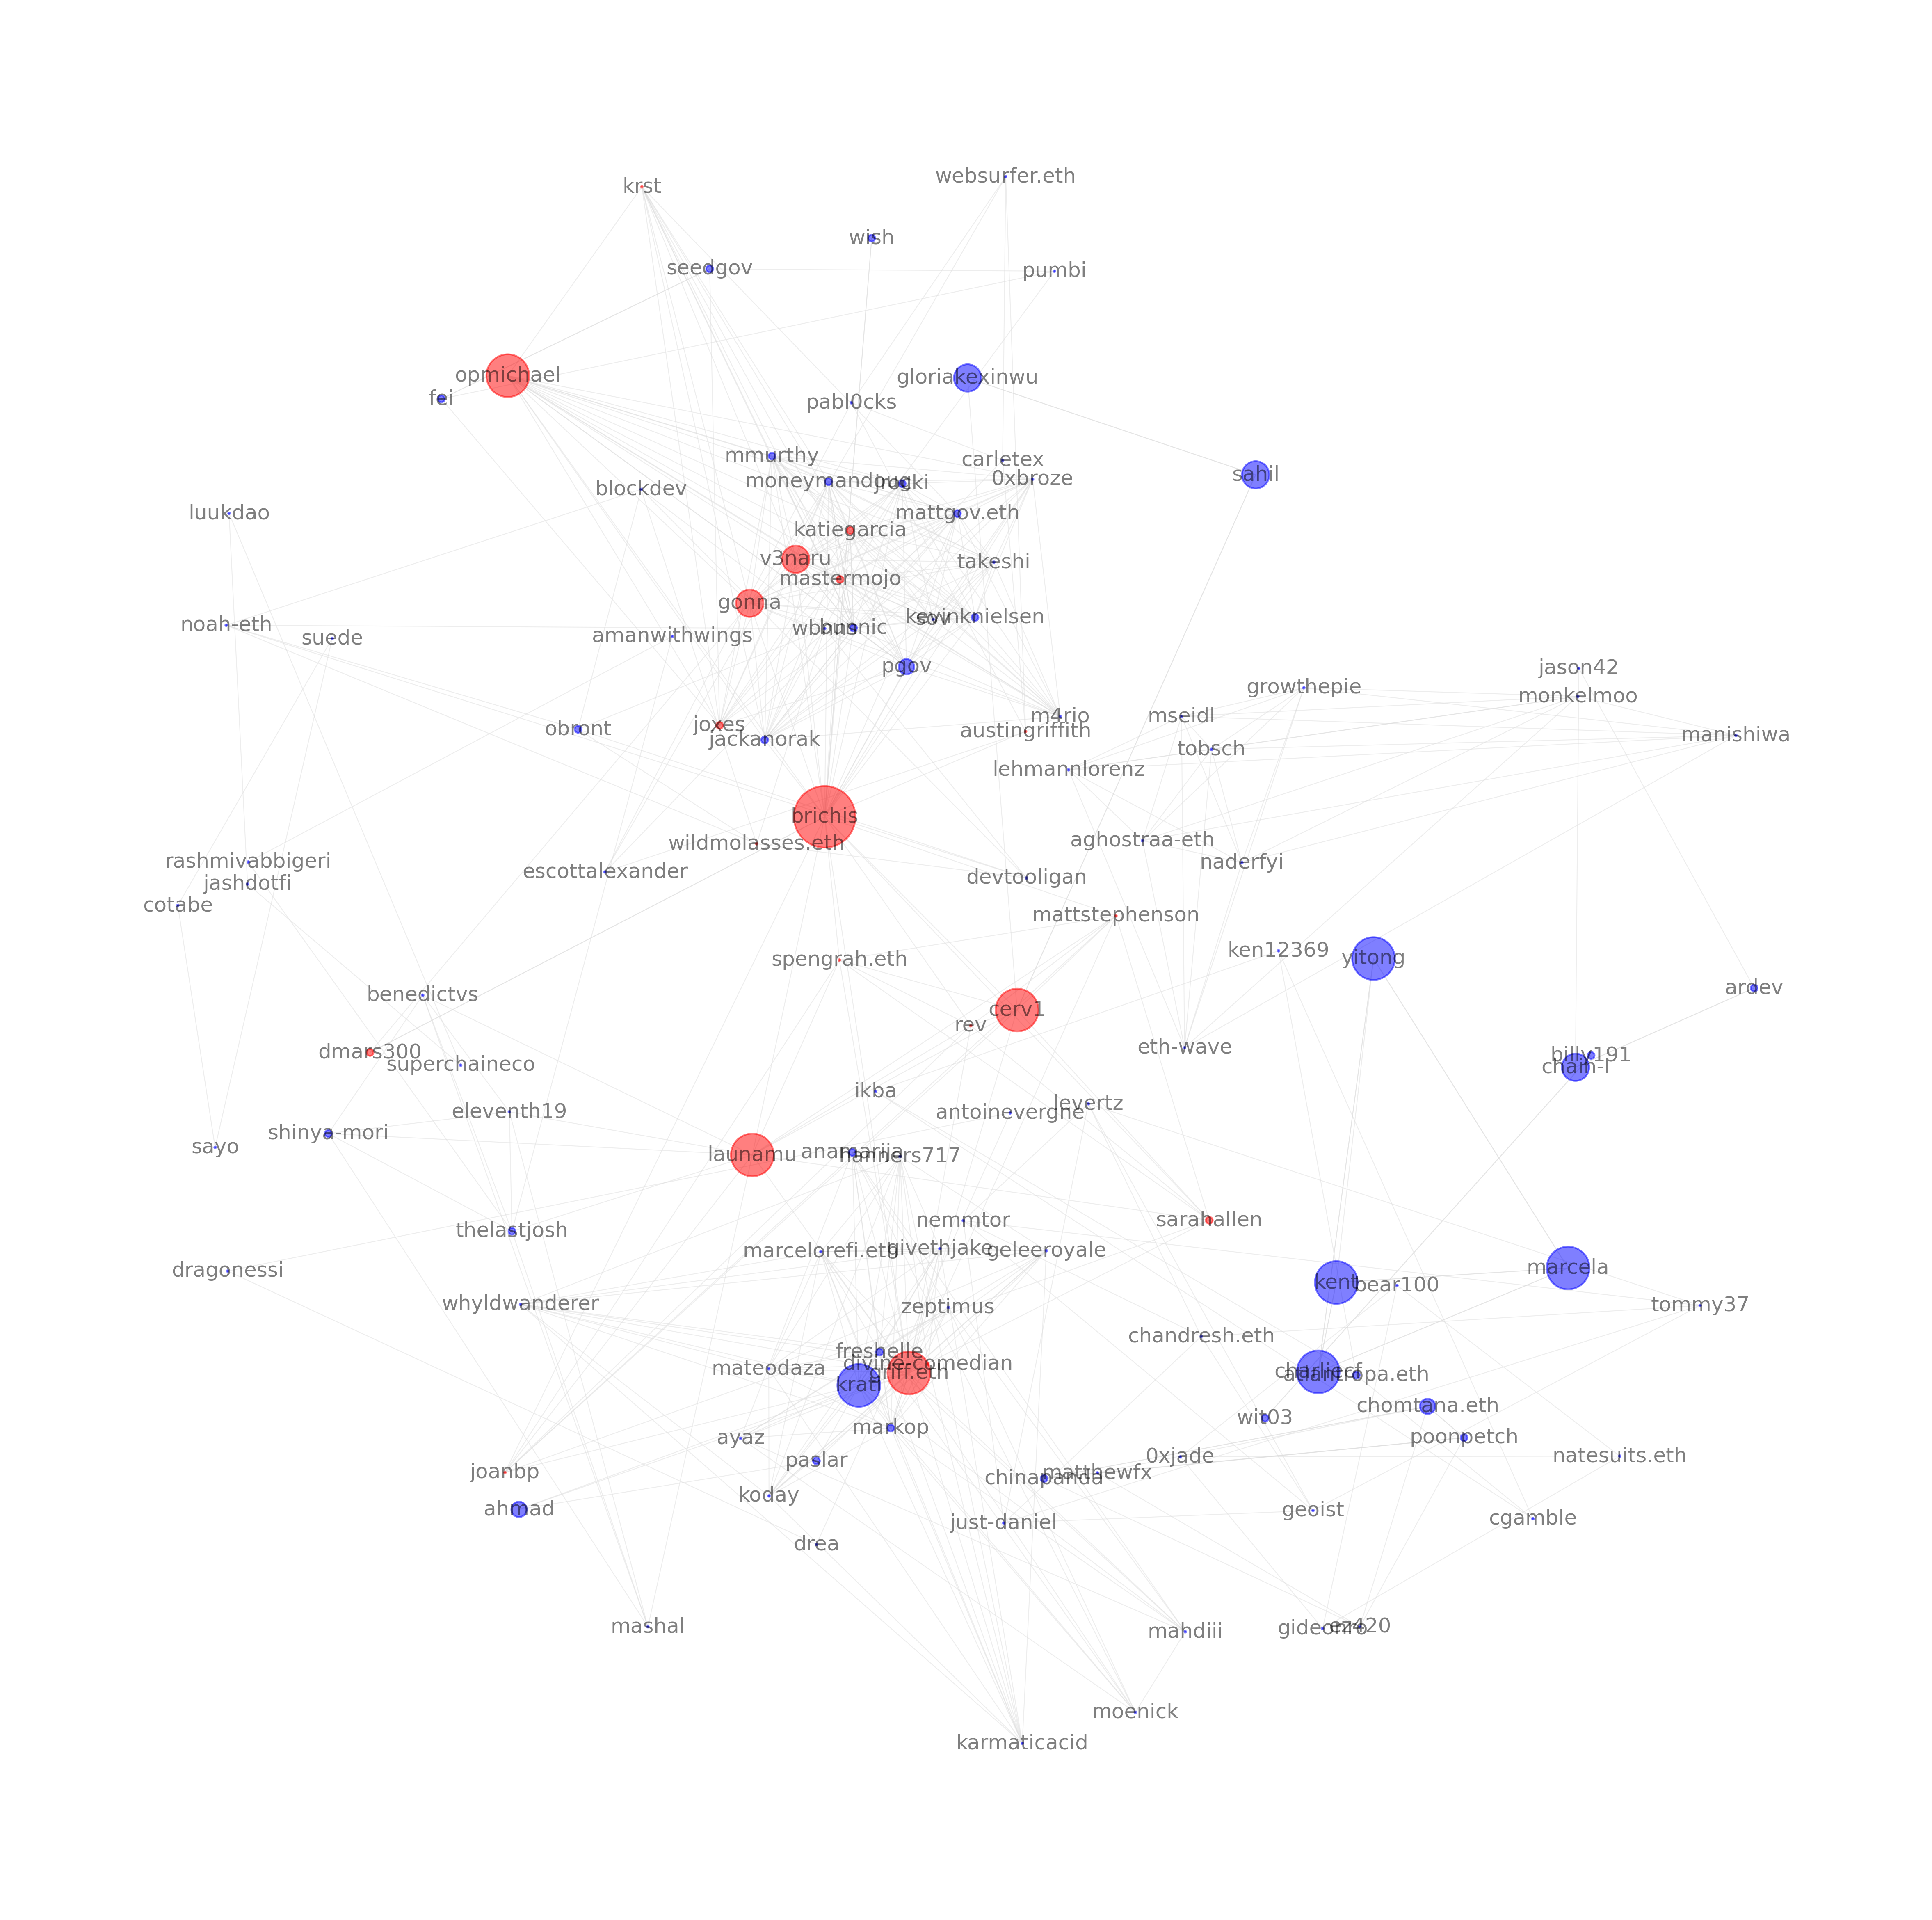

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

df_voters = pd.read_csv('data/_local/rf6_voters.csv')
citizens = list(df_voters[df_voters['Voter Type'] == 'Citizen']['Farcaster username'].unique())

#nodes = [u for u in df_users['username'].unique() if u in citizens]
nodes = list(df_users['username'].unique())
edges = []
for users in df_projects['team_usernames']:
    #uset = set(users).intersection(set(citizens))
    uset = list(users)
    if not len(uset):
        continue
    edges.extend(combinations(uset, 2))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

min_degree = 2
G = nx.k_core(G, min_degree)

degrees = dict(G.degree)
pos = nx.spring_layout(G, k=.5)
node_scaler = 4
#node_sizes = [degrees[d]**node_scaler for d in degrees]
node_sizes = [df_users[df_users['username']==d]['project_name'].nunique()**node_scaler for d in degrees]

degrees_list = [degrees[node] for node in G.nodes()]
node_colors = ['red' if node in citizens else 'blue' for node in G.nodes()]

fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
nx.draw(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    with_labels=True,
    edge_color='#ddd',
    arrows=False,
    width=0.5,
    alpha=0.5
)
plt.show()